## 9. Transformer가 나오기까지

### Positional Encoding

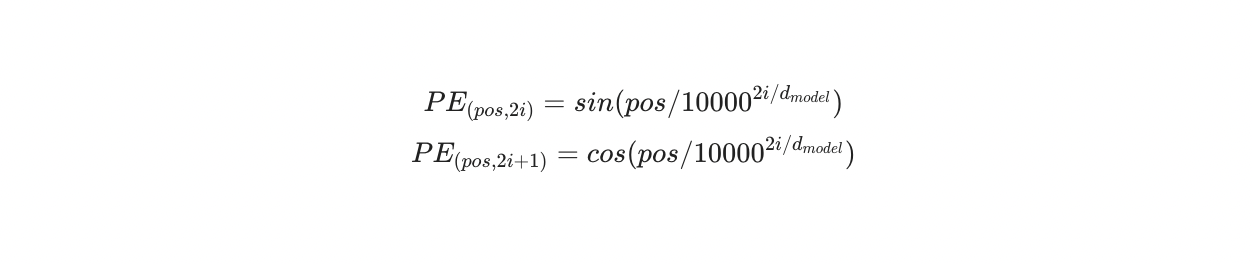

pos는 단어가 위치한 Time-step을 의미하며 i는 Encoding 차원의 Index,d_model은 모델의 Embedding 차원 수입니다. 

이를 Sinusoid(사인파) Embedding이라고 칭합니다

In [1]:
import numpy as np

def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table

pos = 7
d_model = 4
i = 0

print("Positional Encoding 값:\n", positional_encoding(pos, d_model))

print("")
print("if pos == 0, i == 0: ", np.sin(0 / np.power(10000, 2 * i / d_model)))
print("if pos == 1, i == 0: ", np.sin(1 / np.power(10000, 2 * i / d_model)))
print("if pos == 2, i == 0: ", np.sin(2 / np.power(10000, 2 * i / d_model)))
print("if pos == 3, i == 0: ", np.sin(3 / np.power(10000, 2 * i / d_model)))

print("")
print("if pos == 0, i == 1: ", np.cos(0 / np.power(10000, 2 * i + 1 / d_model)))
print("if pos == 1, i == 1: ", np.cos(1 / np.power(10000, 2 * i + 1 / d_model)))
print("if pos == 2, i == 1: ", np.cos(2 / np.power(10000, 2 * i + 1 / d_model)))
print("if pos == 3, i == 1: ", np.cos(3 / np.power(10000, 2 * i + 1 / d_model)))

Positional Encoding 값:
 [[ 0.          1.          0.          1.        ]
 [ 0.84147098  0.99500417  0.00999983  0.9999995 ]
 [ 0.90929743  0.98006658  0.01999867  0.999998  ]
 [ 0.14112001  0.95533649  0.0299955   0.9999955 ]
 [-0.7568025   0.92106099  0.03998933  0.999992  ]
 [-0.95892427  0.87758256  0.04997917  0.9999875 ]
 [-0.2794155   0.82533561  0.05996401  0.999982  ]]

if pos == 0, i == 0:  0.0
if pos == 1, i == 0:  0.8414709848078965
if pos == 2, i == 0:  0.9092974268256817
if pos == 3, i == 0:  0.1411200080598672

if pos == 0, i == 1:  1.0
if pos == 1, i == 1:  0.9950041652780258
if pos == 2, i == 1:  0.9800665778412416
if pos == 3, i == 1:  0.955336489125606


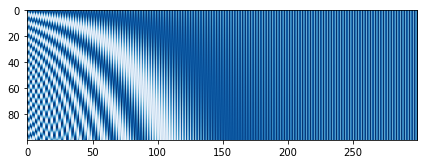

In [2]:
# Position 값이 각 Time-step 별로 고유하다는 것을 시각화를 통해 확인

import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))
plt.imshow(positional_encoding(100, 300), cmap='Blues')
plt.show()

### Scaled Dot-Product Attention

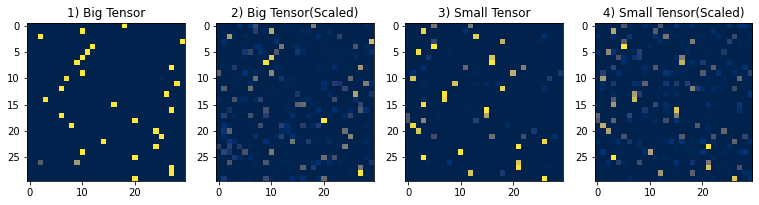

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

def make_dot_product_tensor(shape):
    A = tf.random.uniform(shape, minval=-3, maxval=3)
    B = tf.transpose(tf.random.uniform(shape, minval=-3, maxval=3), [1, 0])

    return tf.tensordot(A, B, axes=1)

length = 30
big_dim = 1024.
small_dim = 10.

big_tensor = make_dot_product_tensor((length, int(big_dim)))
scaled_big_tensor = big_tensor / tf.sqrt(big_dim)
small_tensor = make_dot_product_tensor((length, int(small_dim)))
scaled_small_tensor = small_tensor / tf.sqrt(small_dim)

fig = plt.figure(figsize=(13, 6))

ax1 = fig.add_subplot(141)
ax2 = fig.add_subplot(142)
ax3 = fig.add_subplot(143)
ax4 = fig.add_subplot(144)

ax1.set_title('1) Big Tensor')
ax2.set_title('2) Big Tensor(Scaled)')
ax3.set_title('3) Small Tensor')
ax4.set_title('4) Small Tensor(Scaled)')

ax1.imshow(tf.nn.softmax(big_tensor, axis=-1).numpy(), cmap='cividis')
ax2.imshow(tf.nn.softmax(scaled_big_tensor, axis=-1).numpy(), cmap='cividis')
ax3.imshow(tf.nn.softmax(small_tensor, axis=-1).numpy(), cmap='cividis')
ax4.imshow(tf.nn.softmax(scaled_small_tensor, axis=-1).numpy(), cmap='cividis')

plt.show()

- 히트맵에서 어두운 부분으로는 미분 값이 흐르기 때문에 모델이 넓은 특성을 반영할 수 없게 된다. 


> 즉 ,  히트맵이 선명할수록 모델의 시야가 편협해진다. 

### 인과 관계 마스킹(Causality Masking)

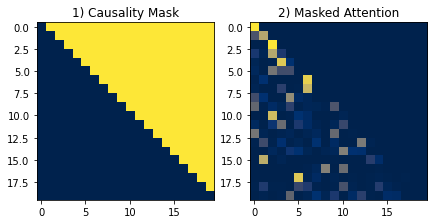

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def make_dot_product_tensor(shape):
    A = tf.random.uniform(shape, minval=-3, maxval=3)
    B = tf.transpose(tf.random.uniform(shape, minval=-3, maxval=3), [1, 0])

    return tf.tensordot(A, B, axes=1)

def generate_causality_mask(seq_len):
    mask = 1 - np.cumsum(np.eye(seq_len, seq_len), 0)
    return mask

sample_tensor = make_dot_product_tensor((20, 512))
sample_tensor = sample_tensor / tf.sqrt(512.)

mask = generate_causality_mask(sample_tensor.shape[0])

fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.set_title('1) Causality Mask')
ax2.set_title('2) Masked Attention')

ax1.imshow((tf.ones(sample_tensor.shape) + mask).numpy(), cmap='cividis')

mask *= -1e9
ax2.imshow(tf.nn.softmax(sample_tensor + mask, axis=-1).numpy(), cmap='cividis')

plt.show()

- 좌측: 실제 마스크의 형태 , 우측: 마스킹이 적용된 Attention
- 마스킹은 마스킹 할 영역을 -∞로 채우고 그 외 영역을 0으로 채운 배열을 Dot-product된 값에 더해주는 방식으로 진행된다. 

### Learning Rate Schedular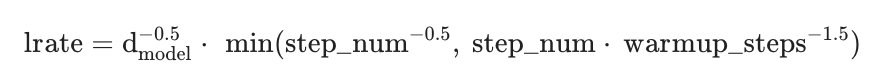

- Warmup_steps까지는 lrate가 선형적으로 증가 하고, 이후에는 Step_num에 비례해 점차 갑소하는 모양새를 보이게 된다. 


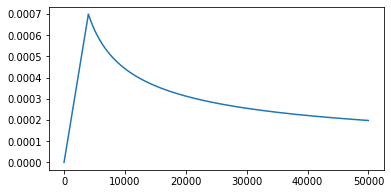

In [3]:
import matplotlib.pyplot as plt
import numpy as np

d_model = 512
warmup_steps = 4000

lrates = []
for step_num in range(1, 50000):
    lrate = (np.power(d_model, -0.5)) * np.min(
        [np.power(step_num, -0.5), step_num * np.power(warmup_steps, -1.5)])
    lrates.append(lrate)

plt.figure(figsize=(6, 3))
plt.plot(lrates)
plt.show()

- 초반 학습이 잘되지 않은 상태에서의 학습 효율이 눌어나고, 어느 정도 학습이 된 후반에는 디테일한 튜닝을 통해 Global Minimum을 찾아가는 효과가 나게 된다. 
- 학습의 초반과 후반은 Warmup_steps 값에 따라 결정된다.